# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                   
Sample_040  P50395                                              17.781
Sample_074  Q14152;Q14152-2;Q96T17;Q96T17-2;Q96T17-4;Q96T17-5   16.936
Sample_097  Q9BUJ0                                              14.937
Sample_088  P10909-3                                            23.480
Sample_047  O75326                                              18.728
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups
Sample_122  Q9NQ30           13.419
Sample_045  P33151           14.687
Sample_005  D6RF35           17.651
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.141
            A0A075B6Q5                 13.244
            A0A075B6R2                 13.584
            A0A075B6S5                 12.810
            A0A087WSY4                 12.685
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.914
            Q9UI40;Q9UI40-2            11.396
            Q9UIW2                     11.800
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.781
            Q9UP79                     12.852
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,12.577,15.050,16.842,19.863,14.073,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.894,19.067,...,15.528,15.576,12.792,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.243,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,13.845,17.705,17.039,14.897,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,11.137,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,12.297,15.345,17.084,18.708,14.249,19.433,7.200,9.846
Sample_207,15.739,16.877,15.469,16.898,15.098,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.215,12.324,13.143,13.186,12.216,13.313,12.816,12.643,12.824,14.632
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.396,19.067,16.127,...,12.189,11.719,12.774,11.639,13.415,14.160,13.115,12.656,11.986,12.789
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.357,12.051,13.422,13.938,13.120,13.778,12.449,14.102,13.059,13.435
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.023,11.770,12.902,11.939,13.364,12.956,12.627,13.755,13.853,12.263
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,11.921,13.262,13.829,12.174,12.956,12.188,14.332,12.018,12.445,13.462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.277,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 386.29it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.15it/s]

100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.00it/s]

100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

100%|██████████| 3/3 [00:00<00:00,  6.32it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.81it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.57it/s]

100%|██████████| 4/4 [00:00<00:00,  3.94it/s]

100%|██████████| 4/4 [00:00<00:00,  4.31it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  8.85it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.61it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.28it/s]

100%|██████████| 5/5 [00:01<00:00,  3.12it/s]

100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.32it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.30it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.79it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.73it/s]

100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

100%|██████████| 6/6 [00:02<00:00,  2.95it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.71it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.36it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.01it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.19it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.38it/s]

100%|██████████| 7/7 [00:02<00:00,  3.52it/s]

100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.16it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.81it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.65it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.60it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.50it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.33it/s]

100%|██████████| 8/8 [00:01<00:00,  4.47it/s]

100%|██████████| 8/8 [00:01<00:00,  4.61it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.38it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.97it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.40it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.88it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.77it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.65it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.75it/s]

100%|██████████| 9/9 [00:01<00:00,  3.84it/s]

100%|██████████| 9/9 [00:01<00:00,  4.59it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.89it/s]

 30%|███       | 3/10 [00:00<00:01,  5.95it/s]

 40%|████      | 4/10 [00:00<00:01,  5.04it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.57it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.39it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.06it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.76it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.72it/s]

100%|██████████| 10/10 [00:03<00:00,  2.66it/s]

100%|██████████| 10/10 [00:03<00:00,  3.29it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.47it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.86it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.48it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.29it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.41it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.10it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.98it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.77it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.52it/s]

100%|██████████| 11/11 [00:03<00:00,  2.60it/s]

100%|██████████| 11/11 [00:03<00:00,  3.22it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.28it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.68it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.81it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.41it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.81it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.14it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.88it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.57it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.48it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.47it/s]

100%|██████████| 12/12 [00:03<00:00,  2.52it/s]

100%|██████████| 12/12 [00:03<00:00,  3.08it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.11it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.83it/s]

 31%|███       | 4/13 [00:00<00:01,  5.03it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.21it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.61it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.13it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.69it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.57it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.50it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.61it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.70it/s]

100%|██████████| 13/13 [00:04<00:00,  2.81it/s]

100%|██████████| 13/13 [00:04<00:00,  3.13it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.23it/s]

 21%|██▏       | 3/14 [00:00<00:01,  5.72it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.91it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.61it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.05it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.80it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.65it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.54it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.58it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.62it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.74it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.03it/s]

100%|██████████| 14/14 [00:04<00:00,  3.14it/s]

100%|██████████| 14/14 [00:04<00:00,  3.13it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.52it/s]

 20%|██        | 3/15 [00:00<00:01,  6.22it/s]

 27%|██▋       | 4/15 [00:00<00:01,  5.65it/s]

 33%|███▎      | 5/15 [00:00<00:01,  5.17it/s]

 40%|████      | 6/15 [00:01<00:02,  3.72it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.20it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.78it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.66it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.57it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.48it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.57it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.95it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.22it/s]

100%|██████████| 15/15 [00:04<00:00,  3.10it/s]

100%|██████████| 15/15 [00:04<00:00,  3.25it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.034 0.001          0.852 0.242       0.155   
2             0.004 0.003      0.052 0.023          0.676 0.095       0.613   
3             0.006 0.006      0.057 0.028          0.677 0.099       0.662   
4             0.004 0.003      0.044 0.019          0.714 0.098       0.672   
5             0.005 0.004      0.054 0.029          0.761 0.096       0.732   
6             0.004 0.003      0.039 0.014          0.794 0.089       0.818   
7             0.004 0.003      0.049 0.025          0.795 0.090       0.814   
8             0.005 0.005      0.065 0.026          0.854 0.078       0.840   
9             0.007 0.007      0.068 0.023          0.849 0.078       0.836   
10            0.005 0.004      0.050 0.022          0.844 0.081       0.839   
11            0.004 0.002      0.045 0.022          0.845 0.081       0.839   
12            0.005 0.005      0.046 0.017          0.837 0.087       0.838   
13            0.005 0.004      0.048 0.020          0.826 0.088       0.827   
14            0.005 0.003      0.047 0.019          0.822 0.088       0.820   
15            0.005 0.005      0.050 0.021          0.834 0.089       0.832   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.089   0.254 0.126                  0.569 0.044        0.857   
2          0.111   0.639 0.089                  0.698 0.069        0.785   
3          0.141   0.664 0.105                  0.715 0.082        0.807   
4          0.138   0.684 0.097                  0.735 0.075        0.812   
5          0.099   0.741 0.075                  0.779 0.064        0.840   
6          0.115   0.800 0.076                  0.830 0.066        0.903   
7          0.116   0.799 0.079                  0.828 0.069        0.901   
8          0.097   0.843 0.067                  0.866 0.058        0.922   
9          0.097   0.839 0.069                  0.863 0.060        0.922   
10         0.097   0.837 0.069                  0.861 0.059        0.920   
11         0.097   0.838 0.068                  0.862 0.059        0.920   
12         0.100   0.834 0.077                  0.858 0.067        0.918   
13         0.098   0.822 0.070                  0.847 0.061        0.917   
14         0.101   0.817 0.074                  0.843 0.064        0.915   
15         0.087   0.829 0.064                  0.853 0.056        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.828 0.086        210.000 0.000  
2          0.073                  0.723 0.103        210.000 0.000  
3          0.069                  0.761 0.094        210.000 0.000  
4          0.070                  0.763 0.099        210.000 0.000  
5          0.069                  0.805 0.092        210.000 0.000  
6          0.049                  0.877 0.061        210.000 0.000  
7          0.051                  0.872 0.063        210.000 0.000  
8          0.048                  0.904 0.060        210.000 0.000  
9          0.048                  0.906 0.058        210.000 0.000  
10         0.049                  0.905 0.058        210.000 0.000  
11         0.049                  0.905 0.059        210.000 0.000  
12         0.052                  0.906 0.060        210.000 0.000  
13         0.052                  0.903 0.061        210.000 0.000  
14         0.052                  0.901 0.062        210.000 0.000  
15         0.051                  0.905 0.059 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 537.52it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.20it/s]

100%|██████████| 3/3 [00:00<00:00,  2.87it/s]

100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.88it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.14it/s]

100%|██████████| 4/4 [00:00<00:00,  4.68it/s]

100%|██████████| 4/4 [00:00<00:00,  4.99it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.61it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.21it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.54it/s]

100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

100%|██████████| 5/5 [00:01<00:00,  3.65it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.92it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.13it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.26it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.28it/s]

100%|██████████| 6/6 [00:01<00:00,  3.63it/s]

100%|██████████| 6/6 [00:01<00:00,  4.14it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.38it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.66it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.79it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.37it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.31it/s]

100%|██████████| 7/7 [00:01<00:00,  3.59it/s]

100%|██████████| 7/7 [00:01<00:00,  4.24it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.43it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.45it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.04it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.54it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.40it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.77it/s]

100%|██████████| 8/8 [00:01<00:00,  3.86it/s]

100%|██████████| 8/8 [00:01<00:00,  4.35it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.07it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.68it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.95it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.74it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.67it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.61it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.54it/s]

100%|██████████| 9/9 [00:03<00:00,  2.29it/s]

100%|██████████| 9/9 [00:03<00:00,  2.64it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.16it/s]

 30%|███       | 3/10 [00:00<00:01,  3.54it/s]

 40%|████      | 4/10 [00:01<00:02,  3.00it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.20it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.29it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.32it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.39it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.28it/s]

100%|██████████| 10/10 [00:03<00:00,  3.15it/s]

100%|██████████| 10/10 [00:03<00:00,  3.30it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.22it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.34it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.53it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.85it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.79it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.18it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.85it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.70it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.50it/s]

100%|██████████| 11/11 [00:03<00:00,  2.66it/s]

100%|██████████| 11/11 [00:03<00:00,  3.16it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.91it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.29it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.96it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.71it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.64it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.40it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.35it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.42it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.48it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.31it/s]

100%|██████████| 12/12 [00:03<00:00,  3.34it/s]

100%|██████████| 12/12 [00:03<00:00,  3.57it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.33it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.67it/s]

 31%|███       | 4/13 [00:00<00:01,  4.86it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.45it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.21it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.76it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.73it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.43it/s]

 77%|███████▋  | 10/13 [00:02<00:01,  2.90it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.76it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.50it/s]

100%|██████████| 13/13 [00:03<00:00,  2.55it/s]

100%|██████████| 13/13 [00:03<00:00,  3.28it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.36it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.65it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.83it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.50it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.26it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.21it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.29it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.47it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.56it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.67it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.30it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.25it/s]

100%|██████████| 14/14 [00:05<00:00,  2.19it/s]

100%|██████████| 14/14 [00:05<00:00,  2.47it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.18it/s]

 20%|██        | 3/15 [00:00<00:03,  3.63it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.36it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.16it/s]

 40%|████      | 6/15 [00:01<00:03,  2.82it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.65it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.69it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.56it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.62it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.92it/s]

 80%|████████  | 12/15 [00:04<00:00,  3.03it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.03it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.11it/s]

100%|██████████| 15/15 [00:04<00:00,  3.19it/s]

100%|██████████| 15/15 [00:04<00:00,  3.03it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.067 0.026          0.816 0.301       0.120   
2             0.003 0.001      0.039 0.010          0.686 0.099       0.513   
3             0.006 0.006      0.052 0.022          0.646 0.105       0.518   
4             0.005 0.004      0.053 0.025          0.640 0.110       0.506   
5             0.004 0.004      0.047 0.019          0.663 0.106       0.561   
6             0.003 0.002      0.034 0.004          0.806 0.105       0.699   
7             0.004 0.002      0.038 0.011          0.781 0.090       0.806   
8             0.003 0.001      0.037 0.008          0.791 0.087       0.816   
9             0.003 0.000      0.041 0.014          0.802 0.082       0.826   
10            0.005 0.005      0.048 0.021          0.802 0.085       0.824   
11            0.003 0.000      0.038 0.009          0.799 0.082       0.823   
12            0.006 0.005      0.050 0.018          0.834 0.086       0.829   
13            0.004 0.004      0.043 0.015          0.837 0.081       0.824   
14            0.006 0.005      0.050 0.021          0.830 0.085       0.813   
15            0.005 0.005      0.047 0.018          0.833 0.093       0.814   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.081   0.201 0.122                  0.553 0.040        0.848   
2          0.116   0.580 0.098                  0.670 0.061        0.728   
3          0.134   0.567 0.106                  0.655 0.071        0.746   
4          0.135   0.556 0.108                  0.648 0.071        0.737   
5          0.116   0.601 0.093                  0.674 0.069        0.741   
6          0.100   0.743 0.079                  0.785 0.063        0.838   
7          0.108   0.788 0.071                  0.818 0.062        0.897   
8          0.100   0.798 0.066                  0.827 0.057        0.905   
9          0.095   0.810 0.063                  0.837 0.055        0.904   
10         0.094   0.808 0.063                  0.835 0.055        0.901   
11         0.096   0.806 0.062                  0.834 0.054        0.901   
12         0.100   0.826 0.066                  0.852 0.057        0.908   
13         0.087   0.826 0.056                  0.851 0.047        0.908   
14         0.091   0.817 0.063                  0.843 0.053        0.909   
15         0.092   0.819 0.070                  0.845 0.058        0.911   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.823 0.088        210.000 0.000  
2          0.067                  0.687 0.079        210.000 0.000  
3          0.077                  0.667 0.090        210.000 0.000  
4          0.075                  0.657 0.085        210.000 0.000  
5          0.076                  0.669 0.093        210.000 0.000  
6          0.064                  0.810 0.088        210.000 0.000  
7          0.055                  0.877 0.065        210.000 0.000  
8          0.054                  0.882 0.078        210.000 0.000  
9          0.055                  0.879 0.077        210.000 0.000  
10         0.055                  0.876 0.079        210.000 0.000  
11         0.056                  0.877 0.078        210.000 0.000  
12         0.051                  0.894 0.061        210.000 0.000  
13         0.049                  0.890 0.059        210.000 0.000  
14         0.049                  0.896 0.055        210.000 0.000  
15         0.049                  0.900 0.054 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1096.84it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 37.40it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 26.20it/s]

100%|██████████| 3/3 [00:00<00:00, 25.73it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 24.73it/s]

100%|██████████| 4/4 [00:00<00:00, 22.13it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 19.79it/s]

100%|██████████| 5/5 [00:00<00:00, 17.24it/s]

100%|██████████| 5/5 [00:00<00:00, 17.58it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 24.69it/s]

100%|██████████| 6/6 [00:00<00:00, 19.86it/s]

100%|██████████| 6/6 [00:00<00:00, 20.33it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.79it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 16.87it/s]

100%|██████████| 7/7 [00:00<00:00, 16.75it/s]

100%|██████████| 7/7 [00:00<00:00, 16.94it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 24.87it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 21.28it/s]

100%|██████████| 8/8 [00:00<00:00, 20.77it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 22.03it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 16.27it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 14.21it/s]

100%|██████████| 9/9 [00:00<00:00, 15.43it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 24.90it/s]

 60%|██████    | 6/10 [00:00<00:00, 17.86it/s]

 80%|████████  | 8/10 [00:00<00:00, 16.77it/s]

100%|██████████| 10/10 [00:00<00:00, 16.00it/s]

100%|██████████| 10/10 [00:00<00:00, 16.89it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 20.86it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 15.35it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 13.82it/s]

 91%|█████████ | 10/11 [00:00<00:00, 14.32it/s]

100%|██████████| 11/11 [00:00<00:00, 14.79it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 25.21it/s]

 50%|█████     | 6/12 [00:00<00:00, 17.20it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 17.10it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 16.23it/s]

100%|██████████| 12/12 [00:00<00:00, 15.60it/s]

100%|██████████| 12/12 [00:00<00:00, 16.52it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 24.72it/s]

 46%|████▌     | 6/13 [00:00<00:00, 17.60it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 16.43it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 16.35it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 15.51it/s]

100%|██████████| 13/13 [00:00<00:00, 16.30it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 27.89it/s]

 43%|████▎     | 6/14 [00:00<00:00, 15.60it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 14.99it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 15.57it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 15.47it/s]

100%|██████████| 14/14 [00:00<00:00, 14.37it/s]

100%|██████████| 14/14 [00:00<00:00, 15.34it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 20.62it/s]

 40%|████      | 6/15 [00:00<00:00, 15.90it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 14.99it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 14.47it/s]

 80%|████████  | 12/15 [00:00<00:00, 14.19it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 14.48it/s]

100%|██████████| 15/15 [00:01<00:00, 14.65it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.037 0.013          0.495 0.445       0.047   
2             0.004 0.003      0.039 0.015          0.383 0.397       0.056   
3             0.002 0.001      0.025 0.008          0.401 0.409       0.063   
4             0.004 0.004      0.047 0.018          0.482 0.338       0.090   
5             0.004 0.002      0.038 0.011          0.481 0.304       0.112   
6             0.004 0.003      0.048 0.021          0.562 0.152       0.312   
7             0.004 0.002      0.036 0.014          0.558 0.131       0.362   
8             0.004 0.003      0.044 0.018          0.526 0.126       0.346   
9             0.004 0.002      0.039 0.014          0.627 0.108       0.527   
10            0.005 0.004      0.045 0.016          0.608 0.097       0.517   
11            0.004 0.003      0.045 0.016          0.605 0.096       0.517   
12            0.005 0.005      0.050 0.019          0.578 0.095       0.493   
13            0.004 0.003      0.049 0.018          0.606 0.093       0.531   
14            0.004 0.001      0.038 0.010          0.614 0.082       0.540   
15            0.004 0.000      0.036 0.006          0.621 0.096       0.531   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.046   0.084 0.081                  0.516 0.024        0.741   
2          0.074   0.091 0.110                  0.513 0.030        0.702   
3          0.073   0.102 0.110                  0.513 0.031        0.678   
4          0.077   0.141 0.107                  0.513 0.030        0.636   
5          0.088   0.167 0.111                  0.511 0.036        0.604   
6          0.096   0.392 0.099                  0.561 0.067        0.603   
7          0.096   0.432 0.095                  0.572 0.068        0.611   
8          0.099   0.409 0.092                  0.554 0.063        0.597   
9          0.127   0.564 0.101                  0.647 0.068        0.715   
10         0.126   0.550 0.094                  0.635 0.065        0.709   
11         0.132   0.548 0.097                  0.633 0.066        0.704   
12         0.144   0.524 0.111                  0.616 0.072        0.697   
13         0.111   0.560 0.088                  0.638 0.063        0.706   
14         0.103   0.568 0.076                  0.644 0.057        0.712   
15         0.123   0.563 0.087                  0.644 0.061        0.710   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.680 0.076        210.000 0.000  
2          0.082                  0.647 0.099        210.000 0.000  
3          0.108                  0.634 0.124        210.000 0.000  
4          0.107                  0.585 0.116        210.000 0.000  
5          0.109                  0.546 0.114        210.000 0.000  
6          0.087                  0.569 0.089        210.000 0.000  
7          0.088                  0.567 0.085        210.000 0.000  
8          0.086                  0.548 0.082        210.000 0.000  
9          0.066                  0.670 0.080        210.000 0.000  
10         0.065                  0.666 0.074        210.000 0.000  
11         0.066                  0.659 0.078        210.000 0.000  
12         0.069                  0.650 0.083        210.000 0.000  
13         0.066                  0.660 0.079        210.000 0.000  
14         0.063                  0.656 0.077        210.000 0.000  
15         0.070                  0.674 0.074 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,9,3,12
score_time,9,1,12
test_precision,8,13,9
test_recall,8,12,14
test_f1,8,12,14
test_balanced_accuracy,8,12,9
test_roc_auc,9,15,1
test_average_precision,9,15,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.72it/s]

 20%|██        | 3/15 [00:00<00:02,  5.21it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.60it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.46it/s]

 40%|████      | 6/15 [00:01<00:02,  4.27it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.98it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.00it/s]

 60%|██████    | 9/15 [00:02<00:01,  4.00it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.83it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.92it/s]

 80%|████████  | 12/15 [00:02<00:00,  3.92it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.65it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.25it/s]

100%|██████████| 15/15 [00:03<00:00,  2.98it/s]

100%|██████████| 15/15 [00:03<00:00,  3.77it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1151.02it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.98it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.99it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.30it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.98it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.74it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.60it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.54it/s]

100%|██████████| 9/9 [00:01<00:00,  4.49it/s]

100%|██████████| 9/9 [00:01<00:00,  4.88it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


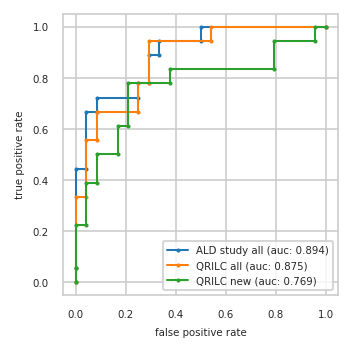

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.000 0.056
2          0.000 0.444     0.000 0.333     0.000 0.222
3          0.042 0.444     0.042 0.333     0.042 0.222
4          0.042 0.667     0.042 0.556     0.042 0.389
5          0.083 0.667     0.083 0.556     0.083 0.389
6          0.083 0.722     0.083 0.667     0.083 0.500
7          0.250 0.722     0.250 0.667     0.167 0.500
8          0.250 0.778     0.250 0.778     0.167 0.611
9          0.292 0.778     0.292 0.778     0.208 0.611
10         0.292 0.889     0.292 0.944     0.208 0.778
11         0.333 0.889     0.542 0.944     0.375 0.778
12         0.333 0.944     0.542 1.000     0.375 0.833
13         0.500 0.944     1.000 1.000     0.792 0.833
14         0.500 1.000       NaN   NaN     0.792 0.944
15         1.000 1.000       NaN   NaN     0.958 0.944
16           NaN   NaN       NaN   NaN     0.958 1.000
17           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,D6R956;P09936
1,Q92752,P60709;P63261,None
2,A0A0A0MRJ7;P12259,A0A0C4DH07;Q8N2S1;Q8N2S1-2;Q8N2S1-3,None
3,Q9BRA2,P10636-2;P10636-6,None
4,P08670,P04430,None
5,P61981,P61981,None
6,C9JF17;P05090,P04075,None
7,P04075,P14174,None
8,P14174,P00338;P00338-3,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


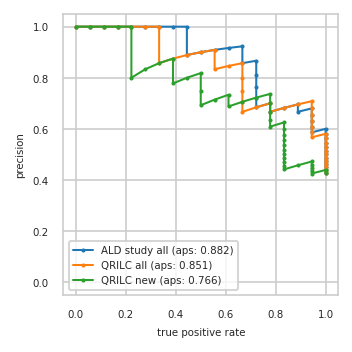

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.425 0.944
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.441 0.833
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.581 1.000     0.581 1.000     0.484 0.833
12         0.600 1.000     0.567 0.944     0.500 0.833
13         0.586 0.944     0.586 0.944     0.517 0.833
14         0.607 0.944     0.607 0.944     0.536 0.833
15         0.630 0.944     0.630 0.944     0.556 0.833
16         0.654 0.944     0.654 0.944     0.577 0.833
17         0.680 0.944     0.680 0.944     0.600 0.833
18         0.667 0.889     0.708 0.944     0.625 0.833
19         0.696 0.889     0.696 0.889     0.609 0.778
20         0.682 0.833     0.682 0.833     0.636 0.778
21         0.667 0.778     0.667 0.778     0.667 0.778
22         0.700 0.778     0.700 0.778     0.700 0.778
23         0.684 0.722     0.684 0.722     0.737 0.778
24         0.722 0.722     0.667 0.667     0.722 0.722
25         0.765 0.722     0.706 0.667     0.706 0.667
26         0.812 0.722     0.750 0.667     0.688 0.611
27         0.867 0.722     0.800 0.667     0.733 0.611
28         0.857 0.667     0.857 0.667     0.714 0.556
29         0.923 0.667     0.846 0.611     0.692 0.500
30         0.917 0.611     0.833 0.556     0.750 0.500
31         0.909 0.556     0.909 0.556     0.818 0.500
32         0.900 0.500     0.900 0.500     0.800 0.444
33         0.889 0.444     0.889 0.444     0.778 0.389
34         1.000 0.444     0.875 0.389     0.875 0.389
35         1.000 0.389     0.857 0.333     0.857 0.333
36         1.000 0.333     1.000 0.333     0.833 0.278
37         1.000 0.278     1.000 0.278     0.800 0.222
38         1.000 0.222     1.000 0.222     1.000 0.222
39         1.000 0.167     1.000 0.167     1.000 0.167
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


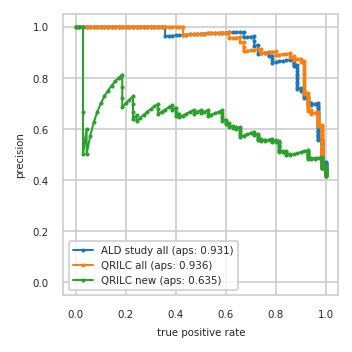

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


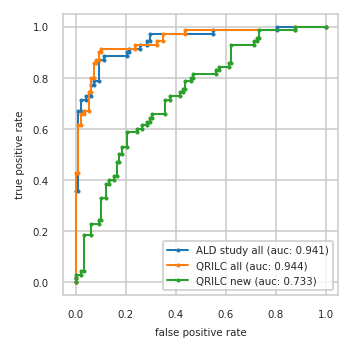

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}